<a href="https://colab.research.google.com/github/kokchun/Machine-learning-AI22/blob/main/Lecture_code/L5-Logistic-regression.ipynb" target="_parent"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; for interacting with the code


---
Logistic regression
---

This is the lecture note for **logistic regression**

<p class = "alert alert-info" role="alert"><b>Note</b> that this lecture note gives a brief introduction to logistic regression. I encourage you to read further about logistic regression. </p>

Read more:

- [Logistic regression wikipedia](https://en.wikipedia.org/wiki/Logistic_regression)
- [ISLRv2 pp 129-141](https://www.statlearning.com/)
- [Precision, accuracy, recall, F-score](https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/)
- [Precision and recall wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)
---


In [109]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 

# plt.style.use("seaborn-white")


## EDA


In [110]:
df = pd.read_csv("../data/Default.csv")
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


In [112]:
df.describe().T. drop('count', axis= 1) # drop removes column count, shich just gives tot number of data points

,count,mean,std,min,25%,50%,75%,max
balance,10000.0,835.374886,483.714985,0.000000,481.731105,823.636973,1166.308386,2654.322576
income,10000.0,33516.981876,13336.639563,771.967729,21340.462903,34552.644802,43807.729272,73554.233495


In [113]:
df["default"].value_counts() # unbalanced dataset since almost all answers are No

No     9667
Yes     333
Name: default, dtype: int64

In [114]:
df["student"].value_counts() # unbalanced dataset

No     7056
Yes    2944
Name: student, dtype: int64

<AxesSubplot: xlabel='balance', ylabel='income'>

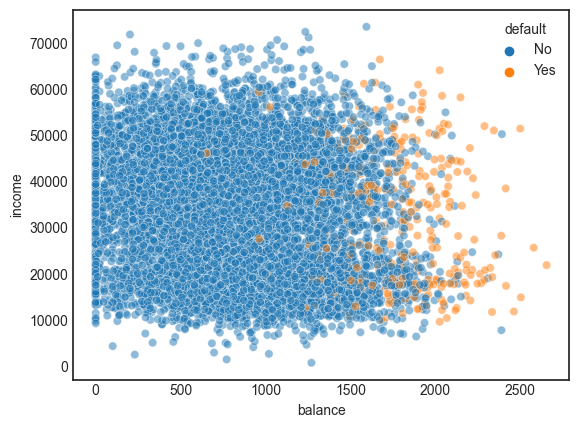

In [115]:
sns.scatterplot(data=df, x="balance", y = "income", hue = "default", alpha = .5)
# we see that the data is very closely packed, which will be hard to train a good model for finding default 
# also the data is highly imbalanced
# balance higher meanign more loans

<AxesSubplot: xlabel='balance', ylabel='income'>

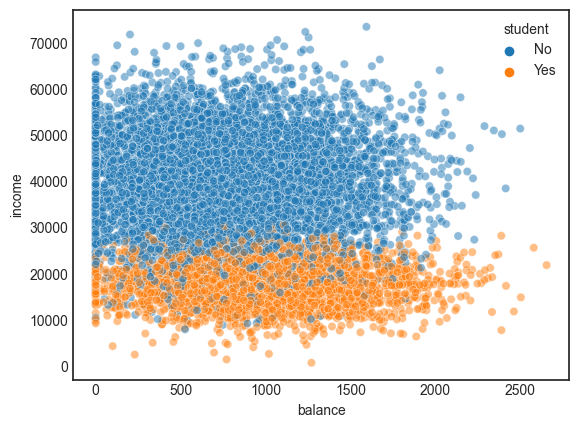

In [116]:
sns.scatterplot(data=df, x="balance", y = "income", hue = "student", alpha = .5)

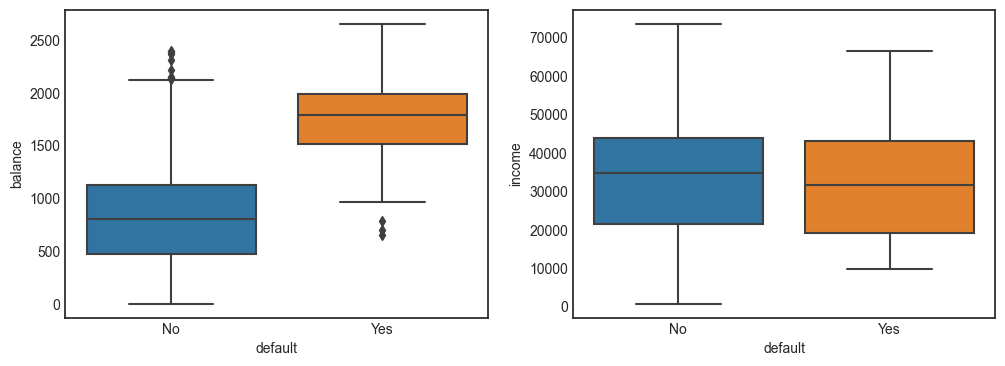

In [117]:
fig, ax = plt.subplots(1, 2, dpi=100, figsize = (12,4))

for axe, col in zip(ax, ["balance", "income"]):
    sns.boxplot(data=df, x="default", y=col, ax=axe)

# TODO: clean up outliers

# Dummy encode categorical variables

## One-hot encoding

The features default and student are categorical. In order to make calculations on those variables, we need to represent them using dummy variables. This is called one-hot encoding.   

In [118]:
pd.get_dummies(df, columns = ["default", "student"]).head() #drop_first is by default False

,balance,income,default_No,default_Yes,student_No,student_Yes
0,729.526495,44361.625074,1,0,1,0
1,817.180407,12106.134700,1,0,0,1
2,1073.549164,31767.138947,1,0,1,0
3,529.250605,35704.493935,1,0,1,0
4,785.655883,38463.495879,1,0,1,0


## Dummy encoding

In [119]:
df = pd.get_dummies(df, columns = ["default", "student"], drop_first=True) # columns which can be calculated from others are removed
df.head()

,balance,income,default_Yes,student_Yes
0,729.526495,44361.625074,0,0
1,817.180407,12106.134700,0,1
2,1073.549164,31767.138947,0,0
3,529.250605,35704.493935,0,0
4,785.655883,38463.495879,0,0


---
## Logistic function 

The response variable that we want to predict is qualitative or categorical. We want to model the conditional probability of default given the balance

$p(X) = P(\textnormal{default = yes|balance}) = P(Y=1|X)$

For example p > 0.5, means we predict a certain person will default with higher than 0.5 probability. Must model $p(X)$ s.t. $p(X)\in[0,1]$. We begin with 

$p(X) = \frac{e^{\beta_0+\beta_1X}}{1+e^{\beta_0+\beta_1X}}$

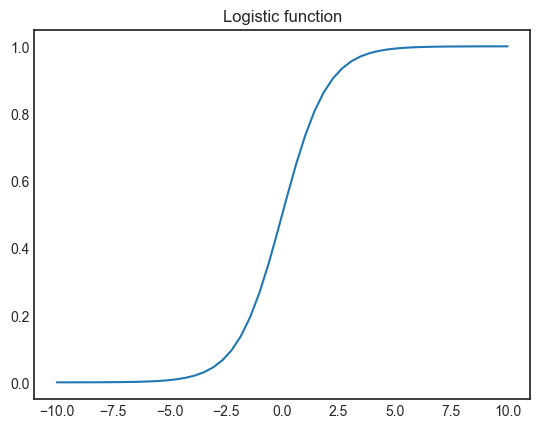

In [120]:
logistic_function = lambda x: np.exp(x)/(1+np.exp(x)) # beta_0 = 0, beta_1 = 1

x = np.linspace(-10, 10)
plt.plot(x, logistic_function(x)) # S-shaped curve
plt.title("Logistic function"); 
# values are constrained to 0 and 1, S-shaped curve

## Logistic regression

### Odds

A convenient way to talk about how a variable relates to another one is to use odds ratio, which is a statistics that can vary from 0 to $\infty$. The odds of a default vs not a default is given by this fraction of probability: 

$$\frac{p(X)}{1-p(X)} = e^{\beta_0+\beta_1X}$$

For example on average 3 of 10 gets a default is given by $0.3/0.7 = 3/7$.

We take logarithm of both sides and obtain the log odds or logit

$$\log{\left(\frac{p(X)}{1-p(X)} \right)} = \beta_0 + \beta_1X$$

This model is linear in $X$ and the parameters $\beta_0, \beta_1$ are chosen to maximize the likelihood function

$$l(\beta_0, \beta_1) = \prod_{y_i = 1}p(x_i)\prod_{y_j=0}(1-p(x_j))$$

In practice the log likelihood function is maximized using an optimization alogrithm such as batch gradient descent, mini-batch gradient descent or stochastic gradient descent.  

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # logistic regression requires scaling

X, y = df.drop("default_Yes", axis=1), df["default_Yes"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

scaled_X_train.mean(), scaled_X_train.std(), scaled_X_test.mean(), scaled_X_test.std()

(7.74173428514736e-17, 1.0, -0.005467573543403287, 0.9870951848219804)

In [122]:
model = LogisticRegression(penalty = None) # dvs no regularisation in this case
model.fit(scaled_X_train, y_train) #training model
model.coef_, model.intercept_ #beta_0 (ballance) beta_1 (income), beta_2 (student_Yes) and intercept

# betas show that balance is most important, incme not som much, student_Yes some too

# ????????????? är beta_0 i beräkningen av intercepteet samma som beta_0 som beskriver ballance???? 

(array([[ 2.888348  ,  0.00687543, -0.28952422]]), array([-6.36240853]))

In [123]:
scaled_X_train[:5]
# 3rd column is student_Yes so 0 or 1 if student but has been scaled to -0,6481 stdnormaldist

array([[-1.7153226 ,  0.10560795, -0.64814602],
       [-0.70441535,  0.26892167, -0.64814602],
       [ 0.03167658, -0.80838645, -0.64814602],
       [ 0.75049546,  0.77729123, -0.64814602],
       [-0.30719754,  0.22117302, -0.64814602]])

## Make prediction on a sample

In [124]:
# create sample for prediction, sample is not scaled
test_sample = pd.DataFrame({"balance": [1500, 1500], "income": [
                           40000, 40000], "student_Yes": [1, 0]})

print(test_sample)
print()

# only difference is that one is student and the other is not
# need to scale the sample
scaled_test_sample = scaler.transform(test_sample)
print(scaled_test_sample)



   balance  income  student_Yes
0     1500   40000            1
1     1500   40000            0

[[ 1.37268368  0.47593334  1.54286221]
 [ 1.37268368  0.47593334 -0.64814602]]


In [125]:
# first column is -1 label i.e. not default, second column is label 1 i.e. default
model.predict_proba(scaled_test_sample)
# we see that being student decreases the chance of getting default 
# returns probability that =0 so p(x=0) and probability that = 1 so p(x=1) for each row in sample
# for sample 1: probablity not default 0.994 and prob default 0.055

array([[0.94485389, 0.05514611],
       [0.90084904, 0.09915096]])

In [126]:
model.predict_proba(scaled_test_sample).sum(axis =1) # probailities sum up to 1 for each row

array([1., 1.])

## Make prediction on all test data

In [127]:
y_pred_probability = model.predict_proba(scaled_X_test)
y_pred_probability

# if assume threshold to be 0.5 the value 0.732 is a Yes, rest is No...

array([[9.30448543e-01, 6.95514567e-02],
       [9.98551323e-01, 1.44867725e-03],
       [9.99985411e-01, 1.45887899e-05],
       ...,
       [9.99735713e-01, 2.64287223e-04],
       [2.67515259e-01, 7.32484741e-01],
       [9.97656416e-01, 2.34358391e-03]])

In [128]:
y_pred = model.predict(scaled_X_test)
y_pred
#... the value of 0.732 in prob corresponds to the 1 in y_pred since assumed threshols is .5

array([0, 0, 0, ..., 0, 1, 0], dtype=uint8)

In [129]:
# testing that threshold is 0.5
y_pred_probability > 0.5

array([[ True, False],
       [ True, False],
       [ True, False],
       ...,
       [ True, False],
       [False,  True],
       [ True, False]])

In [130]:
(y_pred_probability > 0.5)*1

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [0, 1],
       [1, 0]])

In [137]:
# tweeking with different thresholds, here prediction with threshold 0.5 gives y_pred array...
threshold = 0.5

# predicted default_Yes
y_pred = (y_pred_probability > threshold)[:,1]*1
y_pred

array([0, 0, 0, ..., 0, 1, 0])

In [132]:
#... containing 46 yes
y_pred.sum()

46

---

## Evaluation metrics for classification

Confusion matrix

||Pos prediction|Neg prediction|
|---|---|---|
|Pos class|TP|FN|
|Neg class|FP|TN|

- accuracy - ratio of correct predictions to all predictions
    - bad measure when, dataset class is imbalanced, e.g. a fraud model that always predicts non fraudulent could achieve accuracy of close to 1 without having any predictive power. 
- precision - number of positive class predictions that belong to positive class
    - good measure when FP is allowed to be higher e.g. email spam classification 
- recall - sensitivity - number of positive class predictions out of all positive examples 
    - good measure when there is high cost with FN e.g. sick patient of a contageous disease such as Covid-19 quick test
- $F_1$ score - harmonic mean between precision and recall 
    - seeks a balance between precision, recall and uneven class distributions

$ acc = \frac{TP+TN}{Total} $

$ prec = \frac{TP}{TP+FP}$

$ rec = \frac{TP}{TP+FN}$

$ F_1 = 2\frac{prec\cdot recall}{prec + rec}$

In [139]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_test, y_pred)
cm

array([[3177,   13],
       [  77,   33]], dtype=int64)

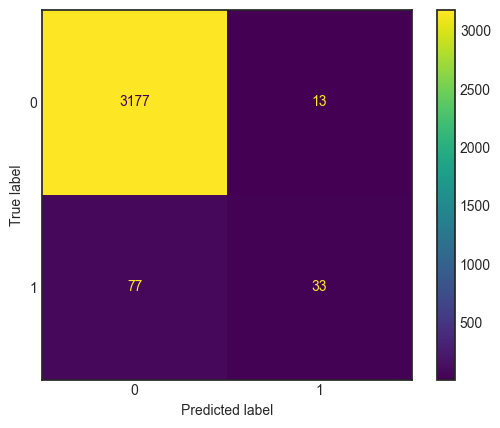

In [140]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

# TN    FP
# FN    TP

Accuracy: 0.973


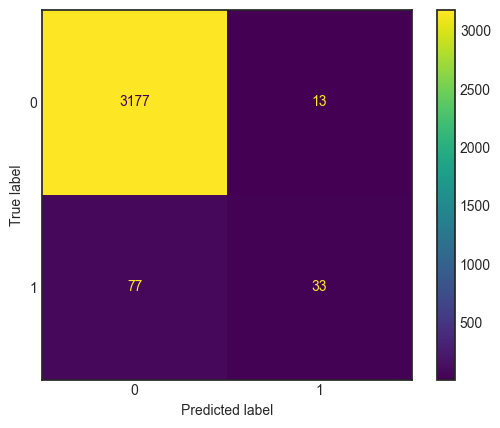

In [141]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report

y_pred = model.predict(scaled_X_test)
acc = accuracy_score(y_test, y_pred)
# note that the accuracy is very high, which is because of the accuracy paradox as the data is highly imbalanced. 
# this means that we could make a model that always classifies negative on default, and achieve very high accuracy
print(f"Accuracy: {acc:.3f}")
cm = confusion_matrix(y_test, y_pred, labels = model.classes_)

disp = ConfusionMatrixDisplay(cm, display_labels = model.classes_)
disp.plot()

In [135]:
# manual calculation

TP = 33
TN = 3177
FP = 13
FN = 77

accuracy = (TP+TN)/(TP+TN+FP+FN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
f1 = 2*(precision*recall)/(precision+recall)

accuracy, recall, precision, f1

(0.9727272727272728, 0.3, 0.717391304347826, 0.4230769230769231)

In [136]:
print(classification_report(y_test, y_pred))

# look at row for default_yes which is 1
# recall and f1 score is very bad here for label 1 indicating that the model having a lot of FN, 
# which means it tends to classify someone that should default as not default
# this can also be seen in the confusion matrix

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3190
           1       0.72      0.30      0.42       110

    accuracy                           0.97      3300
   macro avg       0.85      0.65      0.70      3300
weighted avg       0.97      0.97      0.97      3300



---

Kokchun Giang

[LinkedIn][linkedIn_kokchun]

[GitHub portfolio][github_portfolio]

[linkedIn_kokchun]: https://www.linkedin.com/in/kokchungiang/
[github_portfolio]: https://github.com/kokchun/Portfolio-Kokchun-Giang

---
